In [1]:
import pickle
from pathlib import Path

import lmdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler


# Visualizing Embeddings from VQ-VAE-2 Using UMAP
 Representation learning to see how latent space interacts with known labels
 Author: Akshay Goel

## Import Embeddings in Lightning Memory-Mapped Database Manager (LMDB)
 Embeddings are combined with categorical labels. Current labels are based on pixels of a particular class for a given volume.

In [2]:
embeddings_dir = Path(
    "/myfilestore/efs_backups/akshay/nrrd_vae_cropped_embeddings/"
    "version_8_last.lmdb"
)


In [3]:

embedding_paths = pd.read_csv ("/myfilestore/efs_backups/akshay/"
                               "nrrd_vae_cropped_embeddings/data.csv")

mask_labels = pd.read_csv ("/myfilestore/efs_backups/akshay/"
                           "nrrd_vae_cropped_embeddings/mask_data.csv")

SUFFIX_MASK = "__model_nnunet__mask__cropped"
mask_labels['key'] = mask_labels.apply(lambda x: x['file_name'].split(SUFFIX_MASK)[0], axis=1) 

SUFFIX_VOL = "__vol__cropped"
embedding_paths['key'] = embedding_paths.apply(lambda x: x['file_name'].split(SUFFIX_VOL)[0], axis=1) 

mask_data = embedding_paths.merge(mask_labels, on="key", how="left")



## Read Data fro LMDB

In [4]:

def get_sample_at_idx(idx: int, txn: lmdb.Transaction, unpickle=True):
    sample = txn.get(str(idx).encode())

    if unpickle:
        sample = pickle.loads(sample)  # type: ignore

    return sample


lmdb_env = lmdb.open(
    str(embeddings_dir), readonly=True
)  # for async set lock=False

data = []

# Start a new read transaction
with lmdb_env.begin() as txn:

    # Encode the key the same way as we stored it

    length: int = int(txn.get(b"length"))  # type: ignore
    n_bottleneck_blocks: int = int(txn.get(b"n_bottleneck_blocks"))  # type: ignore

    print(f"dataset length {int(length)}")  # type: ignore
    print(f"n_bottleneck_blocks  {int(n_bottleneck_blocks)}")  # type: ignore
    print("\nFirst few examples:")
    for idx in range(length):
        sample: list = get_sample_at_idx(idx, txn)  # type: ignore
        
        if idx < 3:
            print(
                f"sample #{idx} : {[sample[neck_idx].shape for neck_idx in range(n_bottleneck_blocks)]}"
            )
            
        data.append(sample)

    print("...\n... all embeddings added from disk")

lmdb_env.close()


dataset length 447
n_bottleneck_blocks  3

First few examples:
sample #0 : [(1, 32, 32, 32), (1, 8, 8, 8), (1, 2, 2, 2)]
sample #1 : [(1, 32, 32, 32), (1, 8, 8, 8), (1, 2, 2, 2)]
sample #2 : [(1, 32, 32, 32), (1, 8, 8, 8), (1, 2, 2, 2)]
...
... all embeddings added from disk


In [5]:

assert len(data) == len(mask_data), "Embeddings and mask_data must be 1 to 1"

## Flatten Data to combine Bottle Necks in VQ-VAE-2 into Three Columns

In [6]:
flattened_data = [
    np.asarray([d[bottle_neck_idx].flatten() for d in data], dtype=np.float64)
    for bottle_neck_idx in range(3)
]


## Scale Data for Each Bottle Neck Column

In [7]:

scaled_data = [
    StandardScaler().fit_transform(flattened_data[bottle_neck_idx])
    for bottle_neck_idx in range(3)
]


## Color Scale for Upcoming Plots
 Note: Only first 3 colors are relevant

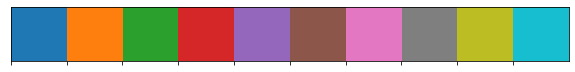

In [8]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

plt.savefig(f"Color Scale")
plt.show()

## Produce UMAP for Each Category and Each Bottle Neck
 Total plots = Number_Categories x Bottle Necks
 Plots are saved as PNG files

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


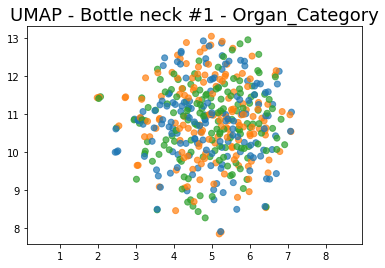

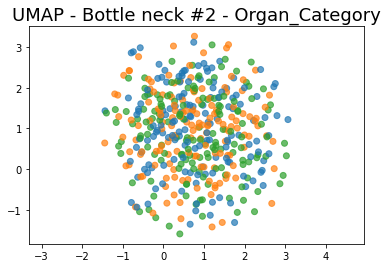

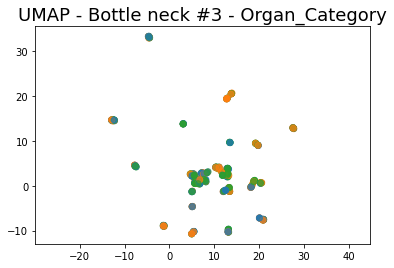

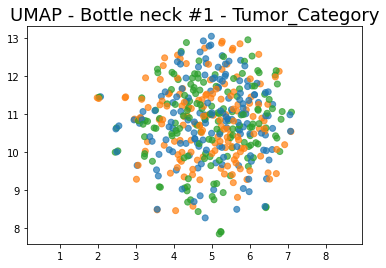

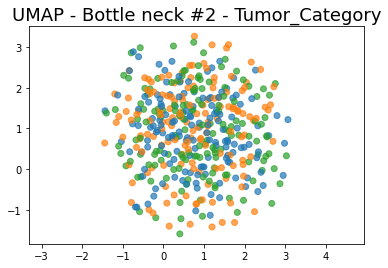

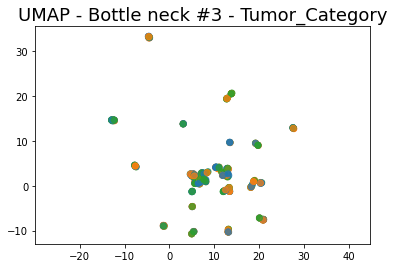

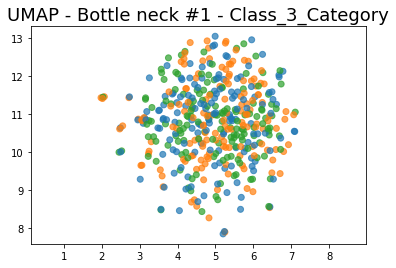

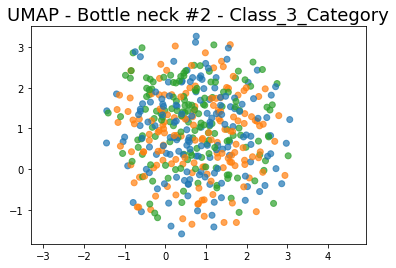

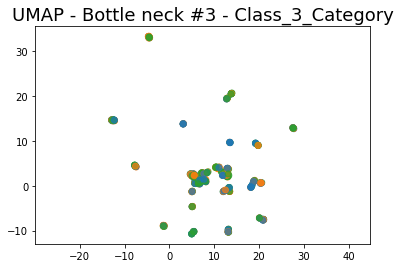

In [9]:
categories = ["Organ_Category", "Tumor_Category", "Class_3_Category"]

for category in categories:
    for bottle_neck_idx in range(3):

        reducer = umap.UMAP(random_state=22, transform_seed=22)
        embedding = reducer.fit_transform(scaled_data[bottle_neck_idx])
        
        color_source = mask_data[category].to_numpy()
        
        f, ax = plt.subplots(1, 1)
        
        scatter = ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=[sns.color_palette()[x] for x in color_source],
            alpha=0.7
        )
        plt.gca().set_aspect("equal", "datalim")
        plt.title(
            f"UMAP - Bottle neck #{bottle_neck_idx+1} - {category}",
            fontsize=18,
        )
        
        plt.show()
        f.savefig(f"{category}_bn={bottle_neck_idx}.png", dpi=300)
